The complex exponential Fourier representation of the potential need not have the same number of basis functions as the Fourier discretizing of the TDSE PDE

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as si
import scipy.linalg as sl

In [98]:
#####################################################
# Computational parameters
#####################################################

# size of spatial domain
L = 15.0

# number of real space grid points (for plotting)
numx = 1025

# number of Fourier basis functions used to discretize
# the TDSE PDE
numdisc = 64  # 64

# number of Fourier basis functions used to approximate
# the potential function (i.e., the model)
nummodel = 72

# real space grid points (for plotting)
xvec = np.linspace(-L, L, numx)

# vector of fourier mode indices
# fournvec = -numfour,...,0,...,numfour
nvec = np.arange(-numdisc, numdisc + 1)
# matrix for converting Fourier representation to real space
# - this converts functions in terms of the Fourier basis,
#   i.e., fn(x) = \sum_{n=-F}^F c_n \phi_n(x)
# - this does not convert vmat to real
fourtox = np.exp(1j * np.pi * np.outer(nvec, xvec) / L) / np.sqrt(2 * L)

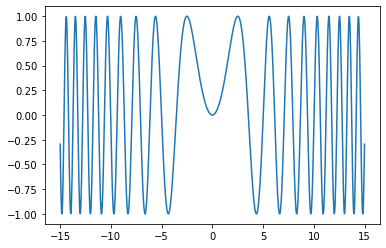

In [99]:
#####################################################
# Specify the potential function
#####################################################

def fn(z):
    # return 0.5 * z**2
    # return np.sin(z)
    return np.sin((0.5 * z)**2)

fnxvec = fn(xvec)

plt.plot(xvec, fnxvec)
plt.show()

In [100]:
#####################################################
# Compute the model representation of the potential
#####################################################

def fourierbasis(n, x):
    return np.exp(1j * np.pi * n * x / L) / np.sqrt(2 * L)

# Compute the coefficients of fn in the model basis
# If nummodel = M, then this should give 2 * M + 1
# coefficients.
nu = []
for thisn in range(-nummodel, nummodel + 1):
    def intgrnd(x):
        return np.conj(fourierbasis(thisn, x)) * fn(x)
    def rintgrnd(x):
        return intgrnd(x).real
    def iintgrnd(x):
        return intgrnd(x).imag
    nu.append(si.quad(rintgrnd, -L, L, limit=100)[0] + 1j * si.quad(iintgrnd, -L, L, limit=100)[0])

nu = np.array(nu)
print('Shape nu:', nu.shape)

Shape nu: (145,)


In [101]:
#####################################################
# Compute vmat from nu
#####################################################

def innerprodfourier(n, x):
    return np.exp(1j * np.pi * n * x / L) / (2 * L)

# This code builds a matrix which can be used to convert from
# the model representation to the discretize representation
# - this code looks like the code above used for computing
#   nu, but it uses a different function (in this case
#   innerprodfourier, which is fourierbasis with an extra
#   factor of 1 / (2 * L) ), also this results in a vector
#   can be used to build a Toeplitz matrix (the above just
#   gives the coefficients)
# - range(-nummodel, nummodel + 1) iterates over all the
#   values of n that the model representation takes (again,
#   this can be different from values of n that the
#   discretizing representation used)
# - range(2 * numdisc + 1) enumerates over the values of n
#   that the Toeplitz representation takes
# - This matrix should be numdisc x numdisc x nummodel
modeltodiscmat = []
for thisj in range(-nummodel, nummodel + 1):
    temptoep = []
    for thisn in range(2 * numdisc + 1):
        def intgrnd(x):
            return np.conj(innerprodfourier(thisn, x)) * fourierbasis(thisj, x)
        def rintgrnd(x):
            return intgrnd(x).real
        def iintgrnd(x):
            return intgrnd(x).imag
        temptoep.append(si.quad(rintgrnd, -L, L, limit=100)[0] + 1j * si.quad(iintgrnd, -L, L, limit=100)[0])

    modeltodiscmat.append(sl.toeplitz(temptoep))

modeltodiscmat = np.array(modeltodiscmat)
print('Shape modeltodiscmat:', modeltodiscmat.shape)

# to use modeltodiscmat like modeltodiscmat @ nu
# we need to transpose the matrix
modeltodiscmat = modeltodiscmat.transpose([1, 2, 0])
print('Shape modeltodiscmat:', modeltodiscmat.shape)

/tmp/ipykernel_59/1599769152.py:33: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  temptoep.append(si.quad(rintgrnd, -L, L, limit=100)[0] + 1j * si.quad(iintgrnd, -L, L, limit=100)[0])


Shape modeltodiscmat: (145, 129, 129)
Shape modeltodiscmat: (129, 129, 145)


Shape fourtox: (129, 1025)
Shape fnmatmodel: (129, 129)
Shape fntopemodel (129,)
Shape fnrec: (1025,)
l2 error fnrec: 0.7971815996197791


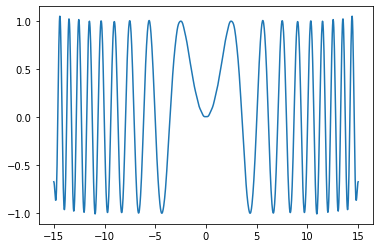

In [102]:
#####################################################
# use modeltodiscmat to compute vmat from the model
# coefficients
#####################################################

print('Shape fourtox:', fourtox.shape)

fnmatmodel = modeltodiscmat @ nu
print('Shape fnmatmodel:', fnmatmodel.shape)

# have to turn the vmat into v(x) = sum_j c_j \phi_j(x)
# form to use transformation matrix fourtox
# The whole top row of vmat = toepvec then there are some
# transformation terms to put the vmat into the righ form
fntopemodel = np.sqrt(2 * L) * np.concatenate([np.conjugate(np.flipud(fnmatmodel[0, 1:(numdisc + 1)])), fnmatmodel[0,:(numdisc + 1)]])
print('Shape fntopemodel', fntopemodel.shape)

fnrec = fntopemodel @ fourtox
print('Shape fnrec:', fnrec.shape)

print('l2 error fnrec:', np.linalg.norm(fnrec - fnxvec))

plt.plot(xvec, fnrec)
plt.show()